# <center>Network Science</center>

## <center>Home Assignment #2: Network models</center>

### <center>Student: *{German Sokolov}*</center>

#### <hr /> General Information

**Due Date:** 28.02.2016 23:59 <br \>
**Late submission policy:** -0.2 points per day <br \>


Please send your reports to <mailto:network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2016] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Problems

### Task 1

Consider Barabasi and Albert dynamical grow model. Two main ingredients of this model are *network growing* and *prefferential attachment*. Implement two restricted B&A-based models:
<br \>

**Model A**
<br \>
Lack of prefferential attachment, that is at each time-step form edges uniformly at random while network keeps growing.

**Model B**
<br \>
Lack of growing, that is fix total number of nodes, on each time-step randomly choose one and form edges with prefferential attachment.
<br \>

1. Generate networks according to the models above ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
4. Is scale-free property conserved in these models?

Analyse results with respect to various parameter settings

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
plt.style.use('ggplot')
%matplotlib inline

Firstly, create necessary function to grow graphs

In [64]:
# Input parameters:
n0 = 10 # number of initial nodes in network
n = 5000 # number of nodes to add into network 
m = 2 # number of initial edges for emerging nodes
nodes_init_num = list(range(n0))
nodes_extra_num = list(range(n0, n + n0))

def make_edges(init_nodes, m, new_nodes, uniform, check_age = False):
    G = nx.Graph()
    edges = []
    nodes = []
    node_degree_check_age = {} # keys = time, values = average degree for initial nodes
    # Firstly, create initial nodes and their connections 
    for node in init_nodes:
        nodes_other = [x for x in init_nodes if x!= node]
        node_edges = []
        while len(node_edges) < m:
            target = random.choice(nodes_other)
            if (node, target) not in node_edges and (target, node) not in edges:
                node_edges.append((node, target))
        edges.extend(node_edges)
        nodes.append(node)
    G.add_edges_from (edges)
    
    # Then, if uniform model, create extra nodes with uniform probability to make connections with existing nodes
    if uniform == True:
        for node in new_nodes:
            node_edges = []
            while len(node_edges) < m:
                target = random.choice(nodes)
                if (node, target) not in node_edges:
                    node_edges.append((node, target))
            edges.extend(node_edges)
            nodes.append(node)
            G.add_edges_from(node_edges)
            node_degree_check_age[node - n0 + 1] = sum(list(G.degree().values())[:n0]) / n0
    
    # If preferential attachment model:
    if uniform == False:
        for node in new_nodes:
            node_edges = []
            k = G.degree()
            p = np.cumsum(list(k.values())) / sum(k.values())
            while len(node_edges) < m:
                ind = np.argmax(p > np.random.random())
                target = ind
                if (node, target) not in node_edges:
                    node_edges.append((node, target))
            edges.extend(node_edges)
            nodes.append(node)
            G.add_edges_from(node_edges)
            node_degree_check_age[node - n0 + 1] = sum(list(G.degree().values())[:n0]) / n0
    if check_age == False:
        return G
    else:
        return node_degree_check_age
    
# Check if there are any duplicate edges or hinges in Graph (either directed or not) (Ex.: check_edges(G.edges()))
def check_edges(edges, directed = False):
    if directed == False:
        edges_inverse = [(i,v) for (v,i) in edges]
        for edge in edges:
            if edge in edges_inverse:
                print ("Edges are duplicate!")
                return edge
    else:
        for edge in edges:
            if edges.count(edge) > 1:
                print ("Edges are duplicate!")
                return edge
    return "OK"

Create <b>small graphs with 50 nodes</b> for both models to check visually that everything has been done correctly.

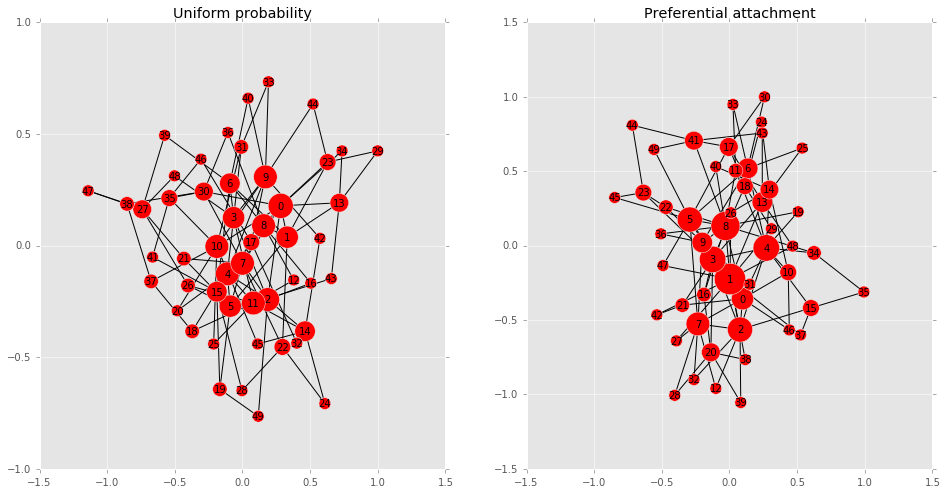

In [65]:
G_unif = make_edges(nodes_init_num, m, list(range(n0,50)), True)
G_pref = make_edges(nodes_init_num, m, list(range(n0,50)), False)
k_unif = G_unif.degree()
k_pref = G_pref.degree()

plt.figure(figsize=(16,8))
plt.subplot(121)
nx.draw_networkx(G_unif, cmap=plt.cm.Reds, node_size = [d*70 for d in k_unif.values()], font_size=10)
plt.title("Uniform probability")
plt.subplot(122)
nx.draw_networkx(G_pref, cmap=plt.cm.Reds, node_size = [d*70 for d in k_pref.values()], font_size=10)
plt.title("Preferential attachment")

<b>Now it is time to create larger graphs and calculate their CDFs, PDFs (both empirical and theoretical ones).</b>

In [31]:
G_unif = make_edges(nodes_init_num, m, nodes_extra_num, True)
G_pref = make_edges(nodes_init_num, m, nodes_extra_num, False)
k_unif = G_unif.degree()
k_pref = G_pref.degree()

CDF_unif = np.cumsum(np.bincount(list(k_unif.values()))) / len(G_unif.nodes())
CDF_pref = np.cumsum(np.bincount(list(k_pref.values()))) / len(G_pref.nodes())
X_pref = np.linspace(0, max(k_pref.values()), CDF_pref.shape[0])
X_unif = np.linspace(0, max(k_unif.values()), CDF_unif.shape[0])
CDF_pref_theor = (n0 + n - m ** 2 * n / (X_pref[m:]) ** 2) / (n0 + n)
CDF_unif_theor = (n0 + n - n * np.exp((m - X_unif[m:]) / m)) / (n0 + n)
PDF_unif_theor = np.exp(1) / m * np.exp(-X_unif[m:] / m)
PDF_pref_theor = 2 * m ** 2 / (X_pref[m:]) ** 3

Empirical CDFs has the same shapes as theoretical ones - it is an indication that the graphs were created correctly.<br \>
One can notice, that there are much more nodes with low degrees in preferential attachment model. This fact can be seen better comparing PDFs.

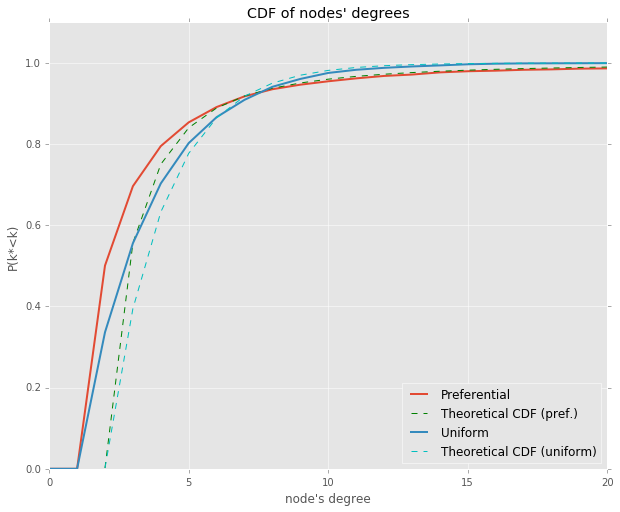

In [32]:
plt.figure(figsize=(10,8))
plt.plot(X_pref, CDF_pref, lw = 2, label = "Preferential")
plt.plot(X_pref[m:], CDF_pref_theor, 'g--', lw = 1, label = "Theoretical CDF (pref.)" )
plt.plot(X_unif, CDF_unif, lw = 2, label = "Uniform")
plt.plot(X_unif[m:], CDF_unif_theor, 'c--', lw = 1, label = "Theoretical CDF (uniform)" )
plt.ylim([0, 1.1])
plt.xlim([0, 20])
plt.ylabel('P(k*<k)')
plt.xlabel("node's degree")
plt.title("CDF of nodes' degrees")
plt.legend(loc = 'best')

No doubts, patterns of theoretical PDFs are same as of empirical ones'. Moreover, as we have seen earlier, the number of nodes with small degree values is greater in Preferential attachment model.

(0, 20)

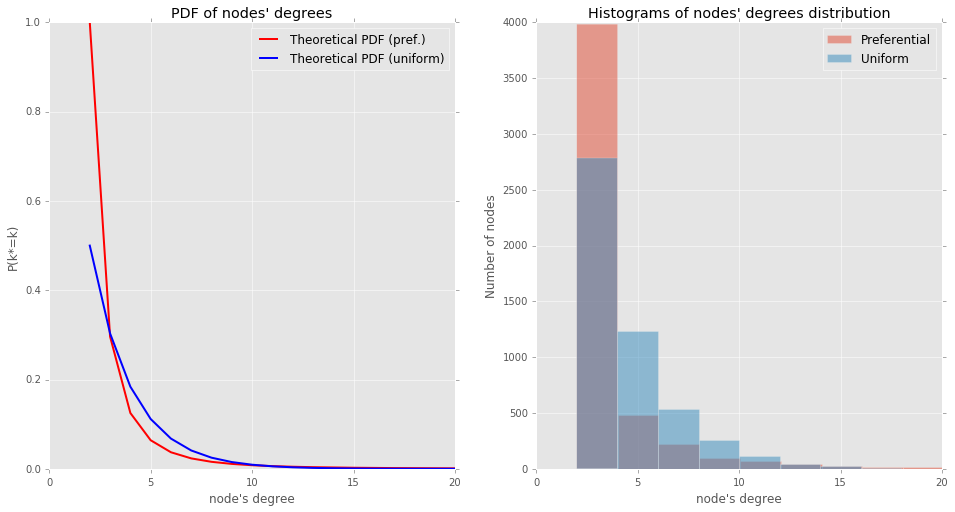

In [33]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(X_pref[m:], PDF_pref_theor, 'r-', lw = 2, label = "Theoretical PDF (pref.)" )
plt.plot(X_unif[m:], PDF_unif_theor, 'b-', lw = 2, label = "Theoretical PDF (uniform)" )
plt.xlim([0, 20])
plt.ylabel('P(k*=k)')
plt.xlabel("node's degree")
plt.title("PDF of nodes' degrees")
plt.legend(loc = 'best')

plt.subplot(122)
plt.hist(list(k_pref.values()), alpha = 0.5, label='Preferential', bins = 11 * X_pref.shape[0] // X_unif.shape[0] + 2)
plt.hist(list(k_unif.values()), alpha = 0.5, label='Uniform')
plt.ylabel('Number of nodes')
plt.xlabel("node's degree")
plt.title("Histograms of nodes' degrees distribution")
plt.legend(loc = 'best')
plt.xlim([0, 20])

#### Let's check how behave the following parameters by increasing size of the network:
- average path length to the number of nodes
- average clustering coefficient to the number of nodes
- average node degee to the nodes "age"

In [67]:
n_range = [10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 5000] # range of network's sizes
aver_path_unif = []
aver_path_pref = []
aver_clust_unif = []
aver_clust_pref = []

for n in n_range:
    nodes_extra_num = list(range(n0, n + n0))
    G_unif = make_edges(nodes_init_num, m, nodes_extra_num, True)
    path_length = nx.average_shortest_path_length(G_unif)
    aver_path_unif.append(path_length)
    aver_cc = nx.average_clustering(G_unif)
    aver_clust_unif.append(aver_cc)
    
    G_pref = make_edges(nodes_init_num, m, nodes_extra_num, False)
    path_length = nx.average_shortest_path_length(G_pref)
    aver_cc = nx.average_clustering(G_pref)
    aver_path_pref.append(path_length)
    aver_clust_pref.append(aver_cc)

<b> 1) Average path length.</b> <br />
Average path length in graph with <b> uniform probability is higher</b> than in preferential attachment graph. In general the average path length is somewhat OK (for example much lower than in graph with regular lattice), but still not enough small to reflect real-world pattern (also it is not so short as in Small-World model).

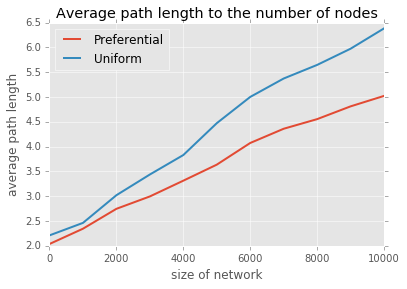

In [68]:
plt.plot(np.linspace(min(n_range), max(n_range), len(n_range)), aver_path_pref, lw = 2, label = "Preferential")
plt.plot(np.linspace(min(n_range), max(n_range), len(n_range)), aver_path_unif, lw = 2, label = "Uniform")
plt.ylabel("average path length")
plt.xlabel("size of network")
plt.title("Average path length to the number of nodes")
plt.legend(loc = 'best')

<b>2) Clustering coefficient. </b> <br />
Clustering coefficient has very small value in comparison with real-world data and with Small-World model in particular (when the probability of edge to be rewired is not too high). This is essential drawback of both Uniform and Preferential attachment models.  

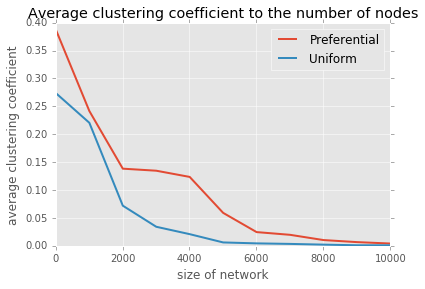

In [69]:
plt.plot(np.linspace(min(n_range), max(n_range), len(n_range)), aver_clust_pref, lw = 2, label = "Preferential")
plt.plot(np.linspace(min(n_range), max(n_range), len(n_range)), aver_clust_unif, lw = 2, label = "Uniform")
plt.ylabel("average clustering coefficient")
plt.xlabel("size of network")
plt.title("Average clustering coefficient to the number of nodes")
plt.legend(loc = 'best')

<b>3) Average node degree </b> <br />
Average node degree for the initial 10 nodes grows as squared root for Preferential attachment model and as logarithmic function (substantially slower) for Uniform model. It explains the absence of nodes with large outstanding degrees in Uniform model - they just cannot be grown with logarithmic speed. <br \>

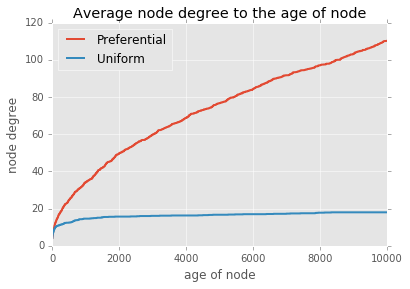

In [70]:
aver_degree_unif = make_edges(nodes_init_num, m, nodes_extra_num, True, check_age=True)
aver_degree_pref = make_edges(nodes_init_num, m, nodes_extra_num, False, check_age=True)

plt.plot(np.linspace(min(aver_degree_pref.keys()), max(aver_degree_pref.keys()), 
                     len(aver_degree_pref.keys())), list(aver_degree_pref.values()), lw = 2, label = "Preferential")
plt.plot(np.linspace(min(aver_degree_unif.keys()), max(aver_degree_unif.keys()), 
                     len(aver_degree_unif.keys())), list(aver_degree_unif.values()), lw = 2, label = "Uniform")
plt.ylabel("node degree")
plt.xlabel("age of node")
plt.title("Average node degree to the age of node")
plt.legend(loc = 'best')

#### Scale - free property.
Scale-free property is preserved in preferential attachment model (PDF has power-law distribution). We can check this fact with plotting cCDF in log-log scale and find out that it is indeed straight line. <br /> 
However, uniformly growing graph has exponential PDF that is why cCDF vanishes in log-log scale. This model does not have scale-free property.

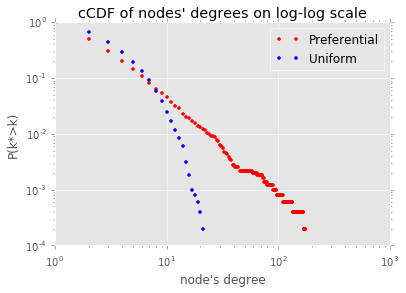

In [71]:
plt.loglog(X_pref, 1 - CDF_pref, 'r.',lw = 1, label = "Preferential")
plt.loglog(X_unif, 1 - CDF_unif, 'b.', lw = 1, label = "Uniform")
plt.ylabel('P(k*>k)')
plt.xlabel("node's degree")
plt.title("cCDF of nodes' degrees on log-log scale")
plt.legend(loc = 'best')

### <hr /> Task 2

Consider the following  "Vertex copying model" of growing network.

At every time step a random vertex from already existing vertices is selected and duplicated together with all edges, such that  every edge of the  vertex
* is copied with probability $q$
* is rewired to any other randomly selected vertex with probability $1-q$


Starting state is defined by some small number of randomly connected vertices.

The model can generate both directed and undirected networks.

1. Generate  graphs based on the model ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
    
Analyse results with respect to various parameter settings

In [134]:
# Input parameters:
n0 = 10 # number of initial nodes in network
t = 5000 # number of time steps
m = 2 # number of initial edges
q = 0.5 # probability for edge to be copied
nodes_init_num = list(range(n0))

def vertex_copy(init_nodes, m, t, q, directed = False, check_age = False):
    if directed == False:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    edges = []
    nodes = []
    node_degree_check_age = {}
    # Firstly, create initial nodes and their connections 
    for node in init_nodes:
        nodes_other = [x for x in init_nodes if x!= node]
        node_edges = []
        while len(node_edges) < m:
            target = random.choice(nodes_other)
            if directed == False:
                if (node, target) not in node_edges and (target, node) not in edges:
                    node_edges.append((node, target))
            else:    
                if (node, target) not in node_edges:
                    node_edges.append((node, target))
        edges.extend(node_edges)
        nodes.append(node)
    G.add_edges_from (edges)
    
    # Then, copy nodes and copy/rewire edges with each new time step
    t_i = 0
    n_i = nodes[-1] + 1
    while t_i <= t:
        parent = random.choice(nodes)
        edges_parent_out = [edge for edge in edges if parent == edge[0]]
        edges_parent_in = [edge for edge in edges if parent == edge[1]]
        edges_parent_in_rev = [(edge[1],edge[0]) for edge in edges_parent_in]
        edges_parent_all = edges_parent_out
        edges_parent_all.extend([(edge[1],edge[0]) for edge in edges_parent_in])
        edges_new = []
        
        if directed == False:
            edges_to_review = edges_parent_all # rewire or copy all undirected edges for each node
        else:
            edges_to_review = edges_parent_out # rewire or copy only out-connections for each node
            
        for edge in edges_to_review:
            if np.random.random() <= q:
                edges_new.append((n_i, edge[1]))
            else:
                nodes_other = [x for x in nodes if x!= edge[1]]
                target = random.choice(nodes_other)
                edges_new.append((n_i, target))
        
        edges.extend(edges_new)
        nodes.append(n_i)
        t_i += 1
        n_i += 1
        G.add_edges_from (edges_new)
        node_degree_check_age[t_i] = sum(list(G.degree().values())[:n0]) / n0
    
    if check_age == False:
        return G
    else:
        return node_degree_check_age

#### Create graph with 2000 nodes with probability q values 0.1, 0.5, 0.9 and plot CDF and PDF. 

In [123]:
G_copy_10 = vertex_copy(nodes_init_num, m, 2000, 0.1, directed = False)
G_copy_50 = vertex_copy(nodes_init_num, m, 2000, 0.5, directed = False)
G_copy_90 = vertex_copy(nodes_init_num, m, 2000, 0.9, directed = False)
k_copy_10 = G_copy_10.degree()
k_copy_50 = G_copy_50.degree()
k_copy_90 = G_copy_90.degree()

# empirical CDFs of nodes' degrees:
CDF_copy_10 = np.cumsum(np.bincount(list(k_copy_10.values()))) / len(G_copy_10.nodes())
CDF_copy_50 = np.cumsum(np.bincount(list(k_copy_50.values()))) / len(G_copy_50.nodes())
CDF_copy_90 = np.cumsum(np.bincount(list(k_copy_90.values()))) / len(G_copy_90.nodes())
X_copy_10 = np.linspace(0, max(k_copy_10.values()), CDF_copy_10.shape[0])
X_copy_50 = np.linspace(0, max(k_copy_50.values()), CDF_copy_50.shape[0])
X_copy_90 = np.linspace(0, max(k_copy_90.values()), CDF_copy_90.shape[0])

CDF and PDF look like Gaussian distribution (PDF is bell-curve). <br \>
- Average number of degrees is very large in comparison with previous models
- Variance grows with probability q (probability not to be rewired)<br \>
When q is low - almost all copied edges are rewired randomly -> distribution is more concentrated.

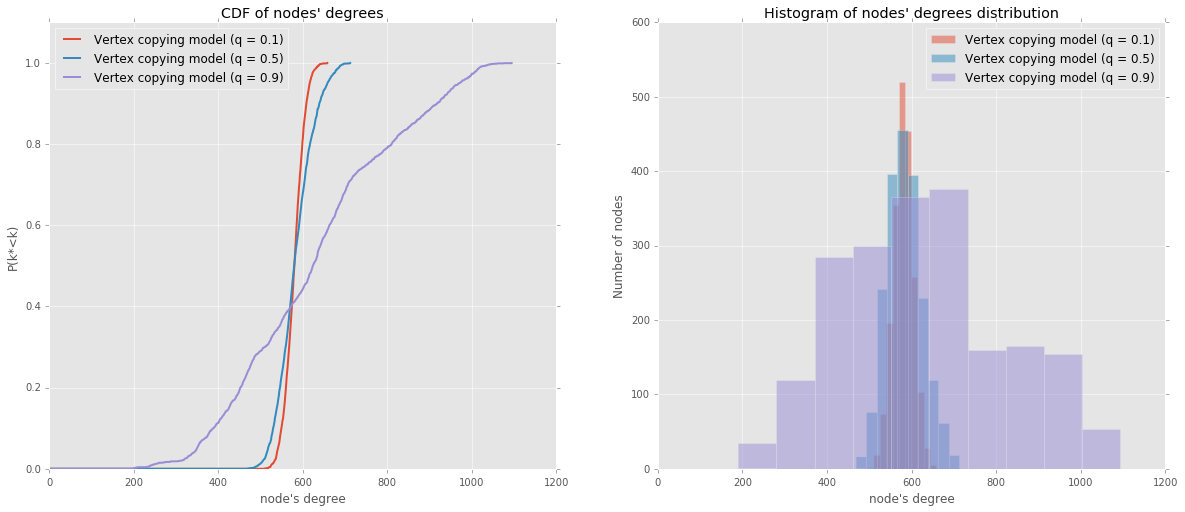

In [127]:
# plot CDFs:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(X_copy_10, CDF_copy_10, lw = 2, label = "Vertex copying model (q = 0.1)")
plt.plot(X_copy_50, CDF_copy_50, lw = 2, label = "Vertex copying model (q = 0.5)")
plt.plot(X_copy_90, CDF_copy_90, lw = 2, label = "Vertex copying model (q = 0.9)")
plt.ylim([0, 1.1])
plt.ylabel('P(k*<k)')
plt.xlabel("node's degree")
plt.title("CDF of nodes' degrees")
plt.legend(loc = 'best')

# histograms of nodes' degree distribution:
plt.subplot(122)
plt.hist(list(k_copy_10.values()), alpha = 0.5, label='Vertex copying model (q = 0.1)')
plt.hist(list(k_copy_50.values()), alpha = 0.5, label='Vertex copying model (q = 0.5)')
plt.hist(list(k_copy_90.values()), alpha = 0.5, label='Vertex copying model (q = 0.9)')
plt.ylabel('Number of nodes')
plt.xlabel("node's degree")
plt.title("Histogram of nodes' degrees distribution")
plt.legend(loc = 'best')

#### Let's check how behave the following parameters by increasing size of the network:
- average path length to the number of nodes
- average clustering coefficient to the number of nodes
- average node degee to the nodes "age"

In [91]:
q = [0.1, 0.5, 0.9]
t_range = [10, 20, 50, 100, 200, 500, 1000, 2000] # range of network's sizes
aver_path_copy = {}
aver_clust_copy = {}

for prob in q:
    aver_path = []
    aver_clust = []
    for t in t_range:
        G_copy = vertex_copy(nodes_init_num, m, t, prob, directed = False)
        path_length = nx.average_shortest_path_length(G_copy)
        aver_path.append(path_length)
        aver_cc = nx.average_clustering(G_copy)
        aver_clust.append(aver_cc)
    aver_path_copy[prob] = aver_path
    aver_clust_copy[prob] = aver_clust

<b> Average path length and clustering coefficient.</b> <br />
Average path length is very short for any probability parameter q because of random character of model (nodes are chosen randomly and edges are either copied or rewired also randomly). <br \>
Average clustering coefficient does not depend much on probability parameter. It is little bit low but still closer to real world than Models from Task 1.  

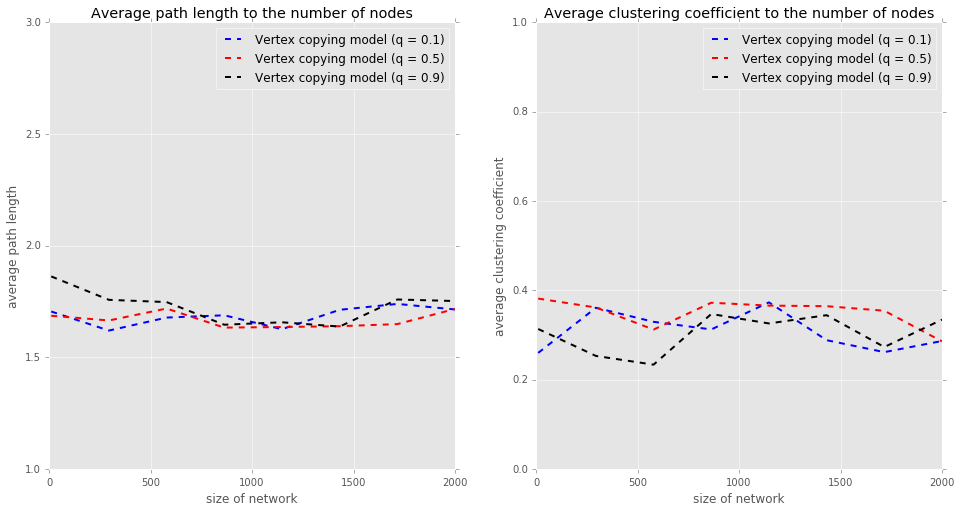

In [125]:
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.plot(np.linspace(min(t_range), max(t_range), len(t_range)), aver_path_copy[0.1], 'b--', lw = 2, 
         label = "Vertex copying model (q = 0.1)")
plt.plot(np.linspace(min(t_range), max(t_range), len(t_range)), aver_path_copy[0.5], 'r--', lw = 2, 
         label = "Vertex copying model (q = 0.5)")
plt.plot(np.linspace(min(t_range), max(t_range), len(t_range)), aver_path_copy[0.9], 'k--', lw = 2, 
         label = "Vertex copying model (q = 0.9)")
plt.ylabel("average path length")
plt.xlabel("size of network")
plt.title("Average path length to the number of nodes")
plt.ylim([1, 3])
plt.legend(loc = 'best')

plt.subplot(122)
plt.plot(np.linspace(min(t_range), max(t_range), len(t_range)), aver_clust_copy[0.1],'b--', lw = 2, 
         label = "Vertex copying model (q = 0.1)")
plt.plot(np.linspace(min(t_range), max(t_range), len(t_range)), aver_clust_copy[0.5],'r--', lw = 2, 
         label = "Vertex copying model (q = 0.5)")
plt.plot(np.linspace(min(t_range), max(t_range), len(t_range)), aver_clust_copy[0.9],'k--', lw = 2, 
         label = "Vertex copying model (q = 0.9)")
plt.ylabel("average clustering coefficient")
plt.xlabel("size of network")
plt.title("Average clustering coefficient to the number of nodes")
plt.ylim([0,1])
plt.legend(loc = 'best')

<b>Average node degree </b> <br />
Since the average nodes' degree in Vertex-copying model network is much higher than in previous models, the speed of degree growth should also be higher. From the graphs below it is clear, that average degree grows linearly (in comparison with squared root and logarithmic speeds from previous models). 

In [135]:
aver_degree_copy_10 = vertex_copy(nodes_init_num, m, 2000, 0.1, directed = False, check_age=True)
aver_degree_copy_50 = vertex_copy(nodes_init_num, m, 2000, 0.5, directed = False, check_age=True)
aver_degree_copy_90 = vertex_copy(nodes_init_num, m, 2000, 0.9, directed = False, check_age=True)

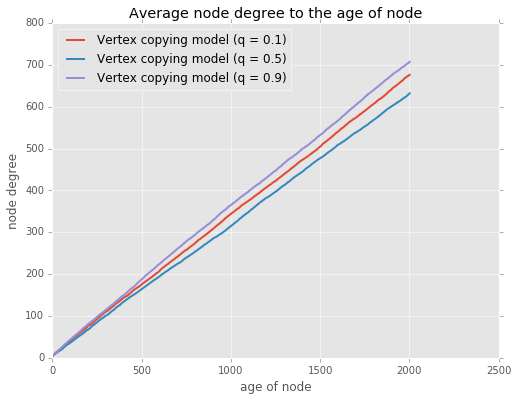

In [138]:
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(min(aver_degree_copy_10.keys()), max(aver_degree_copy_10.keys()), len(aver_degree_copy_10.keys())), 
         list(aver_degree_copy_10.values()), lw = 2, label = "Vertex copying model (q = 0.1)")

plt.plot(np.linspace(min(aver_degree_copy_50.keys()), max(aver_degree_copy_50.keys()), len(aver_degree_copy_50.keys())), 
         list(aver_degree_copy_50.values()), lw = 2, label = "Vertex copying model (q = 0.5)")

plt.plot(np.linspace(min(aver_degree_copy_90.keys()), max(aver_degree_copy_90.keys()), len(aver_degree_copy_90.keys())), 
         list(aver_degree_copy_90.values()), lw = 2, label = "Vertex copying model (q = 0.9)")

plt.ylabel("node degree")
plt.xlabel("age of node")
plt.title("Average node degree to the age of node")
plt.legend(loc = 'best')